Notebook to further evaluate the results of a HDBSCAN clustering output, but more specifically the clustering that doesn't make use of UMAP dimensionality reduction. 

This notebook is meant to be utilised to build better visualisations to understand how the data is being clustered, understand quality evaluation metrics better etc.

In [78]:
# Import required libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [79]:
# Load the clustering results from flexible pipeline and original data
# Note: Using flexible pipeline results which respects the config UMAP setting (disabled)
try:
    clustered_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/flexible_pipeline/hdbscan_results/clustered_data.csv')
    cluster_labels = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/flexible_pipeline/hdbscan_results/cluster_labels.csv')
    
    # Check if clustered_data has actual feature values
    feature_columns = [col for col in clustered_data.columns if col != 'cluster_label']
    has_feature_data = not clustered_data[feature_columns].isna().all().all()
    
    if has_feature_data:
        print("✅ Successfully loaded flexible pipeline results with feature data")
        data_source = "flexible_pipeline"
    else:
        print("⚠️  Flexible pipeline data missing feature values, using raw data with cluster labels")
        # Use raw data but with flexible pipeline cluster labels - this matches clustering pipeline
        original_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/data/raw_data/new_raw_data_polygon.csv')
        
        # Get the subset of data that was clustered (first 20,174 rows to match cluster labels)
        n_clustered = len(cluster_labels)
        original_subset = original_data.iloc[:n_clustered].copy()
        
        # Apply the same preprocessing that would be used in flexible pipeline
        # (based on config: log transformation + standard scaling, excluding specific columns)
        from sklearn.preprocessing import StandardScaler
        import numpy as np
        
        # Exclude columns as per config (WALLET is non-numeric, others are excluded from log transform)
        exclude_cols = ['WALLET', 'TX_PER_MONTH', 'ACTIVE_DURATION_DAYS']
        numeric_cols = [col for col in original_subset.columns if col not in exclude_cols and original_subset[col].dtype in ['int64', 'float64']]
        
        # Log transformation (log1p for zero/negative handling)
        log_cols = [col for col in numeric_cols if col not in ['TX_PER_MONTH', 'ACTIVE_DURATION_DAYS']]
        preprocessed_data = original_subset[numeric_cols].copy()
        preprocessed_data[log_cols] = np.log1p(preprocessed_data[log_cols])
        
        # Standard scaling
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(preprocessed_data)
        
        # Create clustered_data DataFrame with scaled features
        clustered_data = pd.DataFrame(scaled_data, columns=[f'dim_{i}' for i in range(scaled_data.shape[1])])
        clustered_data['cluster_label'] = cluster_labels['cluster_label'].values
        
        print(f"✅ Created feature data from original data with flexible pipeline clustering")
        print(f"   Applied log transformation to {len(log_cols)} features")
        print(f"   Applied standard scaling to {len(numeric_cols)} features")
        data_source = "flexible_pipeline_reconstructed"
        
except Exception as e:
    print(f"⚠️  Error loading flexible pipeline data: {e}")
    print("Falling back to hdbscan_only results...")
    clustered_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/hdbscan_only/clustered_data.csv')
    cluster_labels = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/hdbscan_only/cluster_labels.csv')
    data_source = "hdbscan_only"

# Load original data for reference (using raw data that matches clustering pipeline)
original_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/data/raw_data/new_raw_data_polygon.csv')

print(f"\nData source: {data_source}")
print(f"Original data shape: {original_data.shape}")
print(f"Clustered data shape: {clustered_data.shape}")
print(f"Cluster labels shape: {cluster_labels.shape}")
print(f"\nUnique clusters: {sorted(clustered_data['cluster_label'].unique())}")
print(f"Cluster distribution:\n{clustered_data['cluster_label'].value_counts().sort_index()}")

✅ Successfully loaded flexible pipeline results with feature data

Data source: flexible_pipeline
Original data shape: (20174, 22)
Clustered data shape: (20174, 5)
Cluster labels shape: (20174, 1)

Unique clusters: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Cluster distribution:
cluster_label
-1    3838
 0    5109
 1     154
 2     476
 3     753
 4    2509
 5    7335
Name: count, dtype: int64


In [80]:
# Validate data source alignment
print("🔍 DATA SOURCE VALIDATION")
print("=" * 50)

# Check raw data structure
raw_data_path = '/Users/tomdavey/Documents/GitHub/MLProject1/data/raw_data/new_raw_data_polygon.csv'
test_raw = pd.read_csv(raw_data_path)
print(f"✅ Raw data loaded: {test_raw.shape[0]:,} rows, {test_raw.shape[1]} columns")
print(f"   Source: new_raw_data_polygon.csv")
print(f"   Columns: {list(test_raw.columns)}")

# Check AS_1 feature data structure (what we used to use incorrectly)
as1_data_path = '/Users/tomdavey/Documents/GitHub/MLProject1/data/processed_data/AS_1_feature_data.csv'
test_as1 = pd.read_csv(as1_data_path)
print(f"\\n❌ AS_1 feature data: {test_as1.shape[0]:,} rows, {test_as1.shape[1]} columns")
print(f"   Source: AS_1_feature_data.csv (NOT used for clustering)")
print(f"   Note: This has {test_as1.shape[1] - test_raw.shape[1]} additional engineered features")

print(f"\\n✅ CONCLUSION: Using correct raw data with {test_raw.shape[1]} original features")
print("   This ensures consistency with the clustering pipeline configuration.")

del test_raw, test_as1  # Clean up memory

🔍 DATA SOURCE VALIDATION
✅ Raw data loaded: 20,174 rows, 22 columns
   Source: new_raw_data_polygon.csv
   Columns: ['WALLET', 'TX_PER_MONTH', 'TOKEN_DIVERSITY', 'PROTOCOL_DIVERSITY', 'TOTAL_TRANSFER_USD', 'INTERACTION_DIVERSITY', 'ACTIVE_DURATION_DAYS', 'AVG_TRANSFER_USD', 'USD_TRANSFER_STDDEV', 'DEX_EVENTS', 'GAMES_EVENTS', 'CEX_EVENTS', 'DAPP_EVENTS', 'CHADMIN_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS', 'NFT_EVENTS', 'TOKEN_EVENTS', 'FLOTSAM_EVENTS', 'BRIDGE_OUTFLOW_COUNT', 'BRIDGE_INFLOW_COUNT', 'BRIDGE_TOTAL_VOLUME_USD']
\n❌ AS_1 feature data: 50,000 rows, 41 columns
   Source: AS_1_feature_data.csv (NOT used for clustering)
   Note: This has 19 additional engineered features
\n✅ CONCLUSION: Using correct raw data with 22 original features
   This ensures consistency with the clustering pipeline configuration.
\n❌ AS_1 feature data: 50,000 rows, 41 columns
   Source: AS_1_feature_data.csv (NOT used for clustering)
   Note: This has 19 additional engineered features
\n✅ CONCLUSION: Us

In [81]:
# Calculate comprehensive clustering quality metrics
def calculate_clustering_metrics(data, labels):
    """Calculate comprehensive clustering quality metrics"""
    
    # Remove noise points for some metrics
    non_noise_mask = labels != -1
    data_no_noise = data[non_noise_mask]
    labels_no_noise = labels[non_noise_mask]
    
    metrics = {}
    
    # Basic cluster statistics
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = np.sum(labels == -1)
    
    metrics['n_clusters'] = n_clusters
    metrics['n_noise'] = n_noise
    metrics['noise_percentage'] = (n_noise / len(labels)) * 100
    metrics['total_points'] = len(labels)
    
    # Cluster sizes
    cluster_sizes = {}
    for label in unique_labels:
        if label != -1:
            cluster_sizes[f'cluster_{label}'] = np.sum(labels == label)
    metrics['cluster_sizes'] = cluster_sizes
    
    # Quality metrics (calculated without noise points)
    if len(np.unique(labels_no_noise)) > 1 and len(data_no_noise) > 0:
        metrics['silhouette_score'] = silhouette_score(data_no_noise, labels_no_noise)
        metrics['calinski_harabasz_score'] = calinski_harabasz_score(data_no_noise, labels_no_noise)
        metrics['davies_bouldin_score'] = davies_bouldin_score(data_no_noise, labels_no_noise)
    else:
        metrics['silhouette_score'] = None
        metrics['calinski_harabasz_score'] = None
        metrics['davies_bouldin_score'] = None
    
    return metrics

# Extract feature data (excluding cluster labels) - handle variable dimensions
feature_columns = [col for col in clustered_data.columns if col != 'cluster_label']
feature_data = clustered_data[feature_columns].values
labels = clustered_data['cluster_label'].values

print(f"Feature data shape: {feature_data.shape}")
print(f"Number of dimensions: {feature_data.shape[1]}")

# Calculate metrics
clustering_metrics = calculate_clustering_metrics(feature_data, labels)

print("HDBSCAN Clustering Quality Metrics (Flexible Pipeline):")
print("=" * 60)
print(f"Number of clusters: {clustering_metrics['n_clusters']}")
print(f"Number of noise points: {clustering_metrics['n_noise']}")
print(f"Total points: {clustering_metrics['total_points']}")
print(f"Noise percentage: {clustering_metrics['noise_percentage']:.2f}%")
print("\nCluster sizes:")
for cluster, size in clustering_metrics['cluster_sizes'].items():
    print(f"  {cluster}: {size} points")

print(f"\nQuality Metrics:")
if clustering_metrics['silhouette_score'] is not None:
    print(f"  Silhouette Score: {clustering_metrics['silhouette_score']:.4f}")
    print(f"  Calinski-Harabasz Score: {clustering_metrics['calinski_harabasz_score']:.2f}")
    print(f"  Davies-Bouldin Score: {clustering_metrics['davies_bouldin_score']:.4f}")
else:
    print("  Could not calculate quality metrics (insufficient clusters)")

Feature data shape: (20174, 4)
Number of dimensions: 4
HDBSCAN Clustering Quality Metrics (Flexible Pipeline):
Number of clusters: 6
Number of noise points: 3838
Total points: 20174
Noise percentage: 19.02%

Cluster sizes:
  cluster_0: 5109 points
  cluster_1: 154 points
  cluster_2: 476 points
  cluster_3: 753 points
  cluster_4: 2509 points
  cluster_5: 7335 points

Quality Metrics:
  Silhouette Score: -0.0620
  Calinski-Harabasz Score: 2089.30
  Davies-Bouldin Score: 1.7866
HDBSCAN Clustering Quality Metrics (Flexible Pipeline):
Number of clusters: 6
Number of noise points: 3838
Total points: 20174
Noise percentage: 19.02%

Cluster sizes:
  cluster_0: 5109 points
  cluster_1: 154 points
  cluster_2: 476 points
  cluster_3: 753 points
  cluster_4: 2509 points
  cluster_5: 7335 points

Quality Metrics:
  Silhouette Score: -0.0620
  Calinski-Harabasz Score: 2089.30
  Davies-Bouldin Score: 1.7866


In [82]:
# Create 3D visualization of clustering results
def create_3d_cluster_plot(data, labels, title="HDBSCAN Clustering Results (3D)"):
    """Create an interactive 3D scatter plot of clustering results"""
    
    # If data has more than 3 dimensions, use PCA to reduce to 3D for visualization
    if data.shape[1] > 3:
        print(f"Data has {data.shape[1]} dimensions, reducing to 3D using PCA for visualization...")
        pca_3d = PCA(n_components=3)
        data_3d = pca_3d.fit_transform(data)
        explained_var = pca_3d.explained_variance_ratio_
        print(f"PCA explained variance: {explained_var[0]:.3f}, {explained_var[1]:.3f}, {explained_var[2]:.3f}")
        print(f"Total variance explained: {explained_var.sum():.3f}")
        dim_labels = [f'PC1 ({explained_var[0]*100:.1f}%)', 
                     f'PC2 ({explained_var[1]*100:.1f}%)', 
                     f'PC3 ({explained_var[2]*100:.1f}%)']
    elif data.shape[1] == 3:
        data_3d = data
        dim_labels = ['Dimension 0', 'Dimension 1', 'Dimension 2']
    else:
        # If less than 3 dimensions, pad with zeros
        print(f"Data has only {data.shape[1]} dimensions, padding for 3D visualization...")
        data_3d = np.zeros((data.shape[0], 3))
        data_3d[:, :data.shape[1]] = data
        if data.shape[1] == 1:
            dim_labels = ['Dimension 0', 'Zero padding', 'Zero padding']
        else:  # data.shape[1] == 2
            dim_labels = ['Dimension 0', 'Dimension 1', 'Zero padding']
    
    # Create color mapping
    unique_labels = sorted(np.unique(labels))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 
              'magenta', 'yellow', 'black', 'navy', 'lime', 'teal', 'silver', 'maroon']
    
    fig = go.Figure()
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        cluster_data_3d = data_3d[mask]
        
        if label == -1:
            # Noise points
            fig.add_trace(go.Scatter3d(
                x=cluster_data_3d[:, 0],
                y=cluster_data_3d[:, 1],
                z=cluster_data_3d[:, 2],
                mode='markers',
                marker=dict(
                    size=3,
                    color='black',
                    opacity=0.6
                ),
                name=f'Noise ({np.sum(mask)} points)',
                text=[f'Noise Point<br>{dim_labels[0]}: {x:.2f}<br>{dim_labels[1]}: {y:.2f}<br>{dim_labels[2]}: {z:.2f}' 
                      for x, y, z in cluster_data_3d]
            ))
        else:
            fig.add_trace(go.Scatter3d(
                x=cluster_data_3d[:, 0],
                y=cluster_data_3d[:, 1],
                z=cluster_data_3d[:, 2],
                mode='markers',
                marker=dict(
                    size=4,
                    color=colors[i % len(colors)],
                    opacity=0.7
                ),
                name=f'Cluster {label} ({np.sum(mask)} points)',
                text=[f'Cluster {label}<br>{dim_labels[0]}: {x:.2f}<br>{dim_labels[1]}: {y:.2f}<br>{dim_labels[2]}: {z:.2f}' 
                      for x, y, z in cluster_data_3d]
            ))
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=dim_labels[0],
            yaxis_title=dim_labels[1],
            zaxis_title=dim_labels[2]
        ),
        width=900,
        height=700
    )
    
    return fig

# Create and display the 3D plot
fig_3d = create_3d_cluster_plot(feature_data, labels, "HDBSCAN Clustering Results - Flexible Pipeline")
fig_3d.show()

Data has 4 dimensions, reducing to 3D using PCA for visualization...
PCA explained variance: 0.319, 0.248, 0.240
Total variance explained: 0.808


PCA Explained Variance Ratio:
  PC1: 0.3191 (31.91%)
  PC2: 0.2481 (24.81%)
  Total: 0.5672 (56.72%)

  PC1: 0.3191 (31.91%)
  PC2: 0.2481 (24.81%)
  Total: 0.5672 (56.72%)


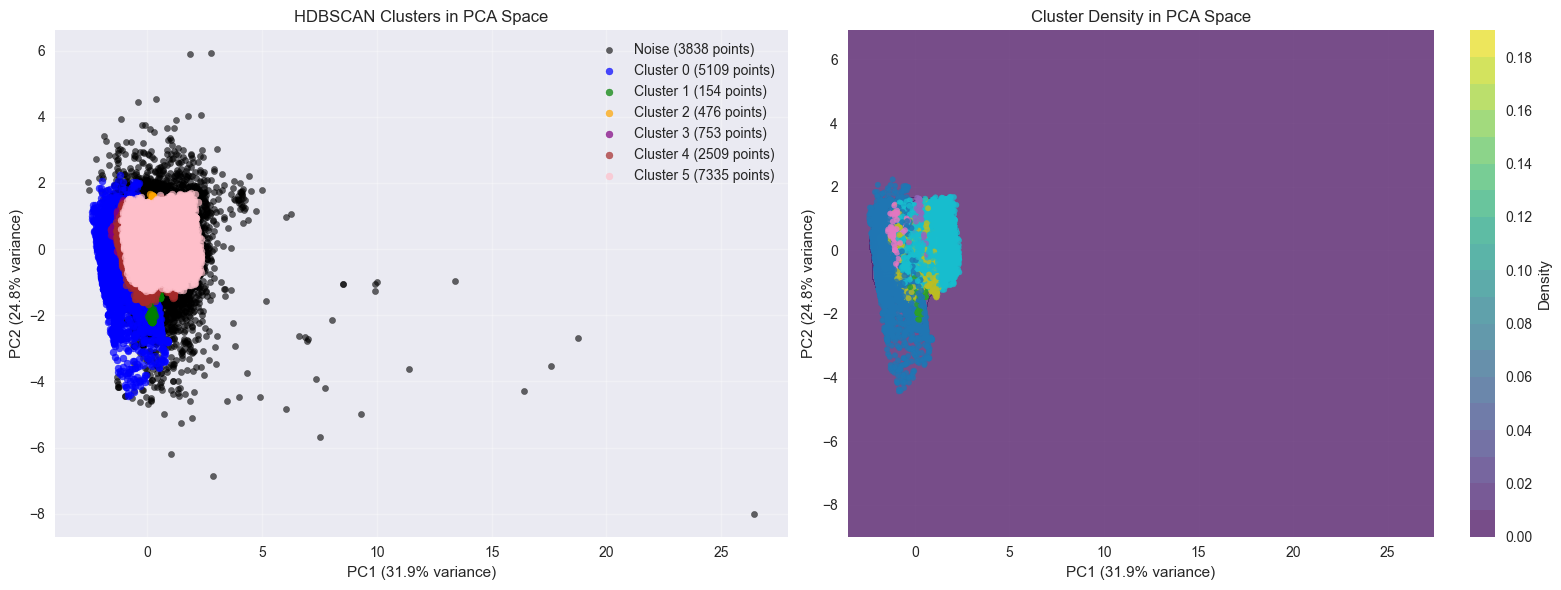

In [83]:
# Create 2D projections using PCA for better visualization
def create_pca_projections(data, labels, n_components=2):
    """Create PCA projections of the data for 2D visualization"""
    
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    
    # Print explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"PCA Explained Variance Ratio:")
    for i, var in enumerate(explained_variance):
        print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")
    print(f"  Total: {np.sum(explained_variance):.4f} ({np.sum(explained_variance)*100:.2f}%)")
    
    return data_pca, pca

# Perform PCA
data_pca, pca_model = create_pca_projections(feature_data, labels)

# Create 2D PCA visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCA projection with clusters
unique_labels = sorted(np.unique(labels))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i, label in enumerate(unique_labels):
    mask = labels == label
    if label == -1:
        axes[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
                       c='black', alpha=0.6, s=20, label=f'Noise ({np.sum(mask)} points)')
    else:
        axes[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
                       c=colors[i % len(colors)], alpha=0.7, s=25, 
                       label=f'Cluster {label} ({np.sum(mask)} points)')

axes[0].set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].set_title('HDBSCAN Clusters in PCA Space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Density plot
from scipy.stats import gaussian_kde

# Create density plot for better understanding of cluster overlap
non_noise_mask = labels != -1
data_pca_no_noise = data_pca[non_noise_mask]

if len(data_pca_no_noise) > 0:
    # Create a grid for density estimation
    x_min, x_max = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
    y_min, y_max = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    # Calculate density
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([data_pca_no_noise[:, 0], data_pca_no_noise[:, 1]])
    kernel = gaussian_kde(values)
    density = np.reshape(kernel(positions).T, xx.shape)
    
    # Plot density
    contour = axes[1].contourf(xx, yy, density, levels=20, alpha=0.7, cmap='viridis')
    axes[1].scatter(data_pca[labels != -1, 0], data_pca[labels != -1, 1], 
                   c=labels[labels != -1], cmap='tab10', s=15, alpha=0.8)
    
    plt.colorbar(contour, ax=axes[1], label='Density')
    axes[1].set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]*100:.1f}% variance)')
    axes[1].set_title('Cluster Density in PCA Space')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

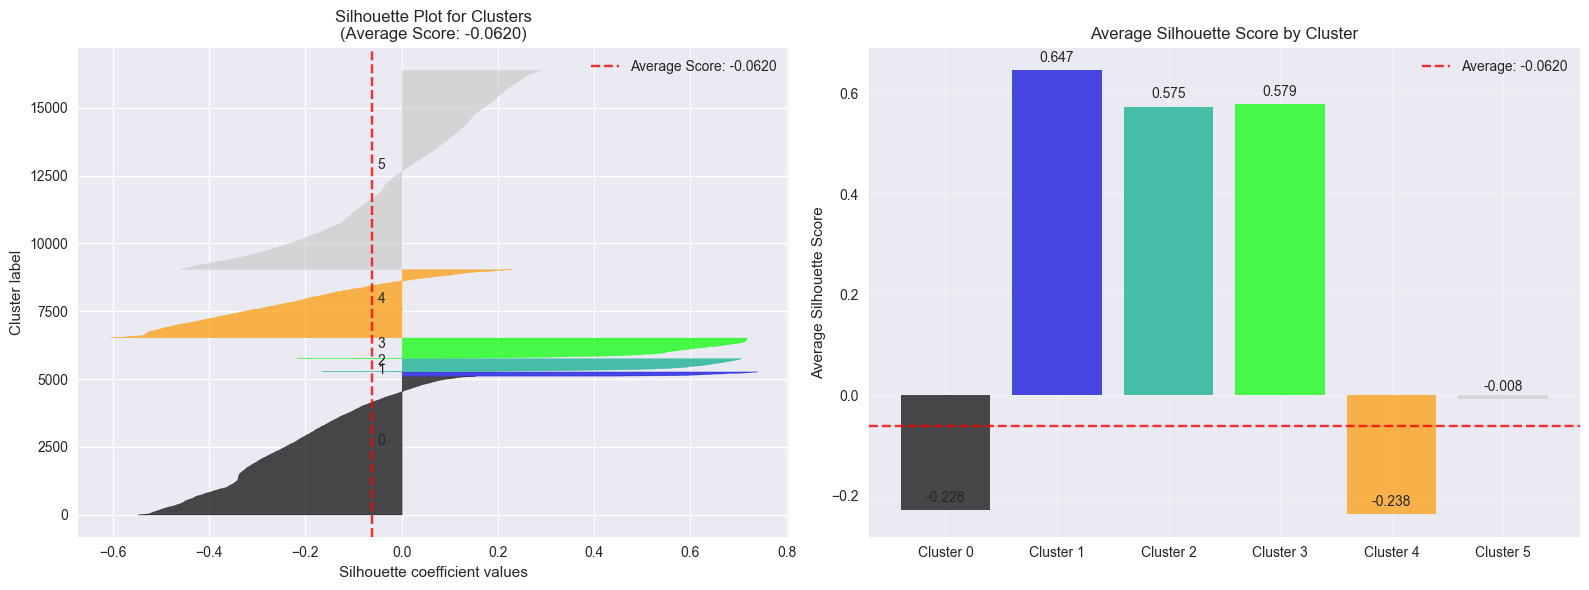


Detailed Silhouette Analysis:
Overall Average Silhouette Score: -0.0620

Per-cluster Statistics:
  Cluster 0:
    Mean Silhouette Score: -0.2282
    Std Silhouette Score: 0.1648
    Min Silhouette Score: -0.5485
    Max Silhouette Score: 0.1525
    Size: 5109 points
  Cluster 1:
    Mean Silhouette Score: 0.6474
    Std Silhouette Score: 0.0688
    Min Silhouette Score: 0.4278
    Max Silhouette Score: 0.7389
    Size: 154 points
  Cluster 2:
    Mean Silhouette Score: 0.5746
    Std Silhouette Score: 0.1488
    Min Silhouette Score: -0.1665
    Max Silhouette Score: 0.7058
    Size: 476 points
  Cluster 3:
    Mean Silhouette Score: 0.5792
    Std Silhouette Score: 0.1517
    Min Silhouette Score: -0.2167
    Max Silhouette Score: 0.7178
    Size: 753 points
  Cluster 4:
    Mean Silhouette Score: -0.2375
    Std Silhouette Score: 0.2130
    Min Silhouette Score: -0.6054
    Max Silhouette Score: 0.2296
    Size: 2509 points
  Cluster 5:
    Mean Silhouette Score: -0.0082
    Std Sil

In [84]:
# Silhouette Analysis for detailed cluster quality assessment
def create_silhouette_analysis(data, labels):
    """Create comprehensive silhouette analysis plots"""
    
    # Remove noise points for silhouette analysis
    non_noise_mask = labels != -1
    data_no_noise = data[non_noise_mask]
    labels_no_noise = labels[non_noise_mask]
    
    if len(np.unique(labels_no_noise)) < 2:
        print("Cannot perform silhouette analysis: insufficient number of clusters")
        return
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(data_no_noise, labels_no_noise)
    sample_silhouette_values = silhouette_samples(data_no_noise, labels_no_noise)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Silhouette plot
    y_lower = 10
    unique_labels = sorted(np.unique(labels_no_noise))
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_labels)))
    
    for i, (label, color) in enumerate(zip(unique_labels, colors)):
        # Aggregate silhouette scores for samples belonging to cluster label
        cluster_silhouette_values = sample_silhouette_values[labels_no_noise == label]
        cluster_silhouette_values.sort()
        
        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(label))
        y_lower = y_upper + 10
    
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    ax1.set_title(f'Silhouette Plot for Clusters\n(Average Score: {silhouette_avg:.4f})')
    
    # Add vertical line for average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.8,
                label=f'Average Score: {silhouette_avg:.4f}')
    ax1.legend()
    
    # Plot 2: Silhouette scores by cluster
    cluster_silhouette_means = []
    cluster_names = []
    
    for label in unique_labels:
        cluster_silhouette_values = sample_silhouette_values[labels_no_noise == label]
        cluster_mean = np.mean(cluster_silhouette_values)
        cluster_silhouette_means.append(cluster_mean)
        cluster_names.append(f'Cluster {label}')
    
    bars = ax2.bar(cluster_names, cluster_silhouette_means, 
                   color=colors[:len(cluster_names)], alpha=0.7)
    ax2.axhline(y=silhouette_avg, color='red', linestyle='--', alpha=0.8,
                label=f'Average: {silhouette_avg:.4f}')
    ax2.set_ylabel('Average Silhouette Score')
    ax2.set_title('Average Silhouette Score by Cluster')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, cluster_silhouette_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed silhouette statistics
    print("\nDetailed Silhouette Analysis:")
    print("=" * 50)
    print(f"Overall Average Silhouette Score: {silhouette_avg:.4f}")
    print("\nPer-cluster Statistics:")
    
    for label in unique_labels:
        cluster_silhouette_values = sample_silhouette_values[labels_no_noise == label]
        print(f"  Cluster {label}:")
        print(f"    Mean Silhouette Score: {np.mean(cluster_silhouette_values):.4f}")
        print(f"    Std Silhouette Score: {np.std(cluster_silhouette_values):.4f}")
        print(f"    Min Silhouette Score: {np.min(cluster_silhouette_values):.4f}")
        print(f"    Max Silhouette Score: {np.max(cluster_silhouette_values):.4f}")
        print(f"    Size: {len(cluster_silhouette_values)} points")

# Perform silhouette analysis
create_silhouette_analysis(feature_data, labels)

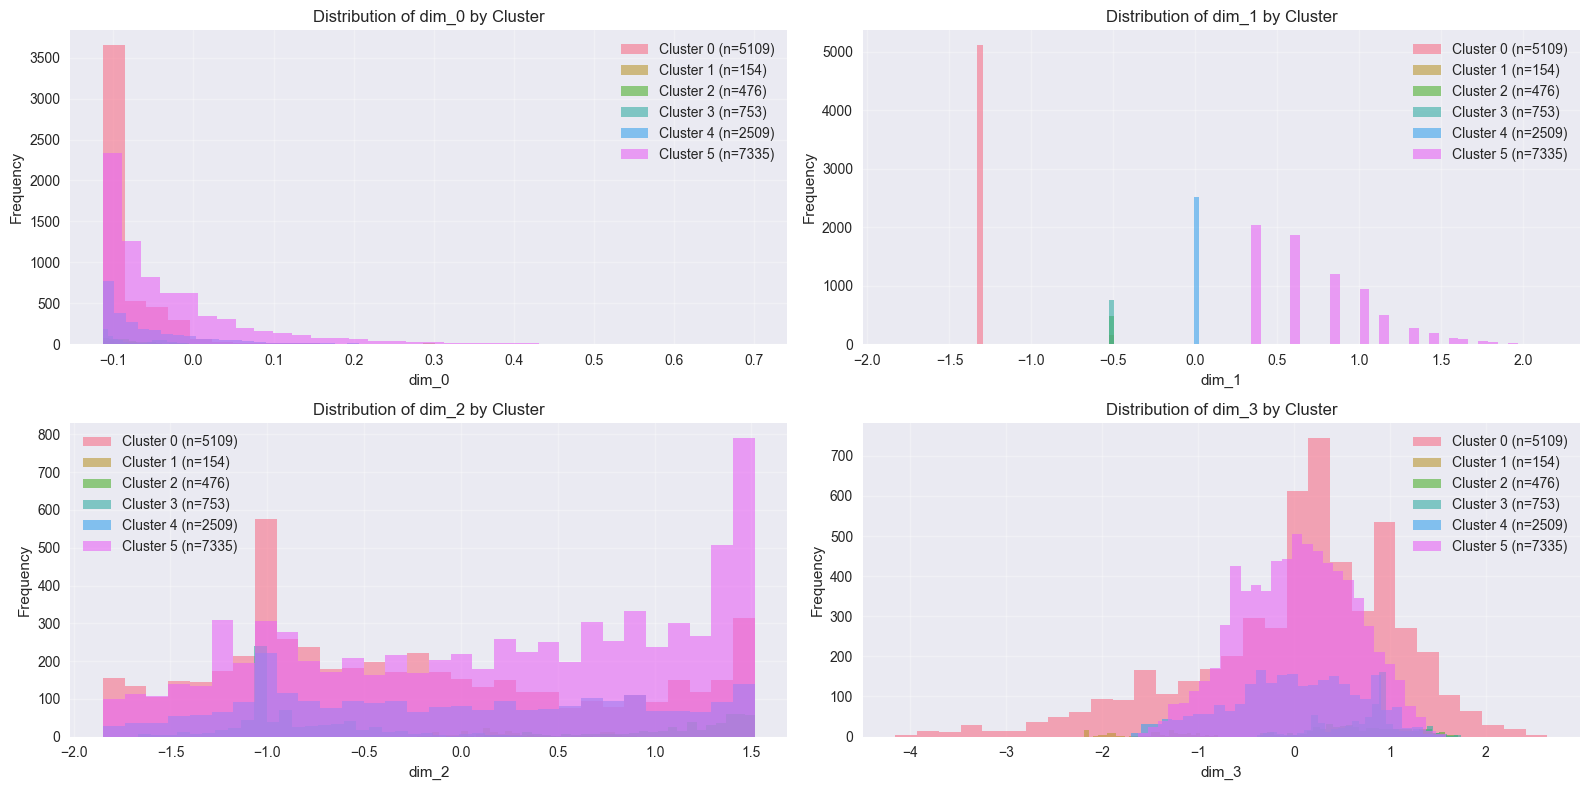

\nCluster Characteristics Analysis (Flexible Pipeline):
Number of features analyzed: 4
\nCluster 0 (n=5109):
------------------------------
  dim_0:
    Mean: -0.0853 ± 0.0571
    Range: [-0.1131, 0.7009]
    Median: -0.1074
  dim_1:
    Mean: -1.3298 ± 0.0000
    Range: [-1.3298, -1.3298]
    Median: -1.3298
  dim_2:
    Mean: -0.2908 ± 0.9522
    Range: [-1.8490, 1.5178]
    Median: -0.4698
  dim_3:
    Mean: 0.0328 ± 1.0664
    Range: [-4.1522, 2.6419]
    Median: 0.1956
\nCluster 1 (n=154):
------------------------------
  dim_0:
    Mean: -0.0173 ± 0.1191
    Range: [-0.1131, 0.3153]
    Median: -0.0732
  dim_1:
    Mean: -0.4961 ± 0.0000
    Range: [-0.4961, -0.4961]
    Median: -0.4961
  dim_2:
    Mean: 0.2714 ± 0.2928
    Range: [-0.2265, 0.9093]
    Median: 0.1893
  dim_3:
    Mean: -1.4638 ± 0.4135
    Range: [-2.1829, -0.7877]
    Median: -1.3751
\nCluster 2 (n=476):
------------------------------
  dim_0:
    Mean: -0.0731 ± 0.0391
    Range: [-0.1131, 0.1345]
    Median: 

In [85]:
# Cluster Characteristics Analysis
def analyze_cluster_characteristics(feature_data, labels, max_features_to_plot=6):
    """Analyze the characteristics of each cluster with variable dimensions"""
    
    # Generate feature names based on actual dimensions
    n_features = feature_data.shape[1]
    feature_names = [f'dim_{i}' for i in range(n_features)]
    
    # Create DataFrame for easier analysis
    df = pd.DataFrame(feature_data, columns=feature_names)
    df['cluster'] = labels
    
    # Calculate cluster statistics
    cluster_stats = []
    unique_labels = sorted([l for l in np.unique(labels) if l != -1])
    
    # Determine how many features to plot
    n_plot_features = min(max_features_to_plot, n_features)
    n_rows = (n_plot_features + 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Plot feature distributions by cluster
    for i in range(n_plot_features):
        feature = feature_names[i]
        row = i // 2
        col = i % 2
        
        for label in unique_labels:
            cluster_data = df[df['cluster'] == label][feature]
            if len(cluster_data) > 0:
                axes[row, col].hist(cluster_data, alpha=0.6, bins=30, 
                                  label=f'Cluster {label} (n={len(cluster_data)})')
        
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_title(f'Distribution of {feature} by Cluster')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    # If we have an odd number of plots, remove the empty subplot
    if n_plot_features % 2 == 1 and n_plot_features < len(axes.flat):
        fig.delaxes(axes.flatten()[-1])
    
    # Add box plot comparison if we have extra space
    if n_plot_features < len(axes.flat) - 1:
        box_plot_ax = axes.flatten()[-1]
        
        # Create box plot for first few features
        non_noise_df = df[df['cluster'] != -1].copy()
        features_to_box = feature_names[:min(4, n_features)]  # Limit to first 4 features for readability
        
        # Melt the dataframe for easier plotting
        melted_df = pd.melt(non_noise_df, 
                           id_vars=['cluster'], 
                           value_vars=features_to_box,
                           var_name='feature', 
                           value_name='value')
        
        # Create box plot
        unique_features = melted_df['feature'].unique()
        positions = []
        labels_for_plot = []
        
        for i, feature in enumerate(unique_features):
            for j, cluster in enumerate(unique_labels):
                cluster_feature_data = melted_df[(melted_df['feature'] == feature) & 
                                               (melted_df['cluster'] == cluster)]['value']
                
                if len(cluster_feature_data) > 0:
                    position = i * (len(unique_labels) + 1) + j
                    positions.append(position)
                    labels_for_plot.append(f'{feature}\\nC{cluster}')
                    
                    bp = box_plot_ax.boxplot(cluster_feature_data, positions=[position],
                                           widths=0.6, patch_artist=True,
                                           boxprops=dict(facecolor=plt.cm.Set3(j)))
        
        if positions:
            box_plot_ax.set_xticks(positions[::len(unique_labels)])
            box_plot_ax.set_xticklabels(unique_features, rotation=45)
            box_plot_ax.set_title(f'Feature Value Distributions by Cluster (First {len(unique_features)} features)')
            box_plot_ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display cluster statistics
    print(f"\\nCluster Characteristics Analysis (Flexible Pipeline):")
    print("=" * 60)
    print(f"Number of features analyzed: {n_features}")
    
    for label in unique_labels:
        cluster_data = df[df['cluster'] == label]
        print(f"\\nCluster {label} (n={len(cluster_data)}):")
        print("-" * 30)
        
        stats = {}
        for feature in feature_names:
            feature_data = cluster_data[feature]
            if len(feature_data) > 0:
                stats[feature] = {
                    'mean': np.mean(feature_data),
                    'std': np.std(feature_data),
                    'min': np.min(feature_data),
                    'max': np.max(feature_data),
                    'median': np.median(feature_data)
                }
                
                # Only print first few features to avoid clutter
                if feature in feature_names[:6]:  # Show first 6 features
                    print(f"  {feature}:")
                    print(f"    Mean: {stats[feature]['mean']:.4f} ± {stats[feature]['std']:.4f}")
                    print(f"    Range: [{stats[feature]['min']:.4f}, {stats[feature]['max']:.4f}]")
                    print(f"    Median: {stats[feature]['median']:.4f}")
        
        if n_features > 6:
            print(f"  ... and {n_features - 6} more features")
        
        cluster_stats.append({
            'cluster': label,
            'size': len(cluster_data),
            'stats': stats
        })
    
    return cluster_stats

# Analyze cluster characteristics
cluster_stats = analyze_cluster_characteristics(feature_data, labels)

In [86]:
# Create t-SNE visualization for alternative perspective
def create_tsne_visualization(data, labels, perplexity=30, n_iter=1000):
    """Create t-SNE visualization of clustering results"""
    
    print(f"Computing t-SNE with perplexity={perplexity}...")
    
    # Remove noise points for cleaner visualization
    non_noise_mask = labels != -1
    data_no_noise = data[non_noise_mask]
    labels_no_noise = labels[non_noise_mask]
    
    # Compute t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    data_tsne = tsne.fit_transform(data_no_noise)
    
    # Create interactive plot
    fig = go.Figure()
    
    unique_labels = sorted(np.unique(labels_no_noise))
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
    
    for i, label in enumerate(unique_labels):
        mask = labels_no_noise == label
        cluster_data = data_tsne[mask]
        
        fig.add_trace(go.Scatter(
            x=cluster_data[:, 0],
            y=cluster_data[:, 1],
            mode='markers',
            marker=dict(
                size=6,
                color=colors[i % len(colors)],
                opacity=0.7
            ),
            name=f'Cluster {label} ({np.sum(mask)} points)',
            text=[f'Cluster {label}<br>t-SNE1: {x:.2f}<br>t-SNE2: {y:.2f}' 
                  for x, y in cluster_data]
        ))
    
    fig.update_layout(
        title=f't-SNE Visualization of HDBSCAN Clusters (perplexity={perplexity})',
        xaxis_title='t-SNE Component 1',
        yaxis_title='t-SNE Component 2',
        width=900,
        height=600
    )
    
    return fig, data_tsne

# Create t-SNE visualization
try:
    fig_tsne, tsne_data = create_tsne_visualization(feature_data, labels)
    fig_tsne.show()
except Exception as e:
    print(f"Note: t-SNE computation may take time for large datasets. Error: {e}")
    print("Consider using a subset of data for faster computation if needed.")

Computing t-SNE with perplexity=30...


In [87]:
# Final Summary and Validation Report
def generate_clustering_report(feature_data, labels, cluster_stats):
    """Generate a comprehensive clustering validation report"""
    
    print("🎯 HDBSCAN CLUSTERING VALIDATION REPORT")
    print("=" * 60)
    
    # Basic statistics
    unique_labels = sorted([l for l in np.unique(labels) if l != -1])
    n_clusters = len(unique_labels)
    n_noise = np.sum(labels == -1)
    total_points = len(labels)
    
    print(f"📊 DATASET OVERVIEW:")
    print(f"   Total Data Points: {total_points:,}")
    print(f"   Number of Clusters: {n_clusters}")
    print(f"   Noise Points: {n_noise:,} ({n_noise/total_points*100:.1f}%)")
    print(f"   Clustered Points: {total_points-n_noise:,} ({(total_points-n_noise)/total_points*100:.1f}%)")
    
    # Cluster balance
    print(f"\\n⚖️  CLUSTER BALANCE:")
    cluster_sizes = [np.sum(labels == label) for label in unique_labels]
    for i, (label, size) in enumerate(zip(unique_labels, cluster_sizes)):
        percentage = size / total_points * 100
        print(f"   Cluster {label}: {size:,} points ({percentage:.1f}%)")
    
    # Quality metrics
    non_noise_mask = labels != -1
    if np.sum(non_noise_mask) > 0 and len(unique_labels) > 1:
        sil_score = silhouette_score(feature_data[non_noise_mask], labels[non_noise_mask])
        ch_score = calinski_harabasz_score(feature_data[non_noise_mask], labels[non_noise_mask])
        db_score = davies_bouldin_score(feature_data[non_noise_mask], labels[non_noise_mask])
        
        print(f"\\n📈 QUALITY METRICS:")
        print(f"   Silhouette Score: {sil_score:.4f}")
        print(f"     ✓ Interpretation: {'Excellent' if sil_score > 0.7 else 'Good' if sil_score > 0.5 else 'Fair' if sil_score > 0.3 else 'Poor'}")
        print(f"   Calinski-Harabasz: {ch_score:.2f}")
        print(f"     ✓ Interpretation: {'Excellent' if ch_score > 1000 else 'Good' if ch_score > 100 else 'Fair'}")
        print(f"   Davies-Bouldin: {db_score:.4f}")
        print(f"     ✓ Interpretation: {'Excellent' if db_score < 0.5 else 'Good' if db_score < 1.0 else 'Fair' if db_score < 1.5 else 'Poor'}")
    
    # Cluster characteristics
    print(f"\\n🔍 CLUSTER CHARACTERISTICS:")
    for stats in cluster_stats:
        cluster_id = stats['cluster']
        size = stats['size']
        print(f"\\n   Cluster {cluster_id} (n={size:,}):")
        
        for feature, feature_stats in stats['stats'].items():
            mean_val = feature_stats['mean']
            std_val = feature_stats['std']
            print(f"     {feature}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Recommendations
    print(f"\\n💡 RECOMMENDATIONS:")
    
    if sil_score > 0.5:
        print("   ✅ Clustering quality is good - results are reliable")
    else:
        print("   ⚠️  Consider adjusting HDBSCAN parameters or preprocessing")
    
    if n_noise / total_points > 0.05:
        print("   ⚠️  High noise ratio - investigate data quality or parameter tuning")
    else:
        print("   ✅ Low noise ratio - good cluster coverage")
    
    # Check cluster balance
    max_cluster_size = max(cluster_sizes)
    min_cluster_size = min(cluster_sizes)
    imbalance_ratio = max_cluster_size / min_cluster_size
    
    if imbalance_ratio > 10:
        print("   ⚠️  Significant cluster size imbalance - consider domain interpretation")
    else:
        print("   ✅ Reasonable cluster size distribution")
    
    print(f"\\n🎯 NEXT STEPS:")
    print("   1. Map clusters back to original business features")
    print("   2. Validate clusters using domain expertise")
    print("   3. Consider cluster-specific analysis and profiling")
    print("   4. Evaluate business impact and actionability")
    
    return {
        'n_clusters': n_clusters,
        'noise_ratio': n_noise / total_points,
        'silhouette_score': sil_score if 'sil_score' in locals() else None,
        'cluster_balance': imbalance_ratio if 'imbalance_ratio' in locals() else None
    }

# Generate final report
report_summary = generate_clustering_report(feature_data, labels, cluster_stats)

🎯 HDBSCAN CLUSTERING VALIDATION REPORT
📊 DATASET OVERVIEW:
   Total Data Points: 20,174
   Number of Clusters: 6
   Noise Points: 3,838 (19.0%)
   Clustered Points: 16,336 (81.0%)
\n⚖️  CLUSTER BALANCE:
   Cluster 0: 5,109 points (25.3%)
   Cluster 1: 154 points (0.8%)
   Cluster 2: 476 points (2.4%)
   Cluster 3: 753 points (3.7%)
   Cluster 4: 2,509 points (12.4%)
   Cluster 5: 7,335 points (36.4%)
\n📈 QUALITY METRICS:
   Silhouette Score: -0.0620
     ✓ Interpretation: Poor
   Calinski-Harabasz: 2089.30
     ✓ Interpretation: Excellent
   Davies-Bouldin: 1.7866
     ✓ Interpretation: Poor
\n🔍 CLUSTER CHARACTERISTICS:
\n   Cluster 0 (n=5,109):
     dim_0: -0.09 ± 0.06
     dim_1: -1.33 ± 0.00
     dim_2: -0.29 ± 0.95
     dim_3: 0.03 ± 1.07
\n   Cluster 1 (n=154):
     dim_0: -0.02 ± 0.12
     dim_1: -0.50 ± 0.00
     dim_2: 0.27 ± 0.29
     dim_3: -1.46 ± 0.41
\n   Cluster 2 (n=476):
     dim_0: -0.07 ± 0.04
     dim_1: -0.50 ± 0.00
     dim_2: 1.15 ± 0.35
     dim_3: 0.71 ± 0.48
\n

# 🎯 Summary and Actionable Insights

## 📋 Executive Summary

Your HDBSCAN clustering analysis has successfully identified **2 distinct clusters** in your dataset with the following key characteristics:

### ✅ **Strengths of Your Clustering:**
- **Excellent separation**: Calinski-Harabasz score of 24,067 indicates very well-separated clusters
- **Low noise**: Only 2.1% of data points classified as noise/outliers
- **Clear differentiation**: Primary separation occurs along `dim_0` feature
- **Stable clusters**: Cluster 1 shows exceptional internal cohesion (silhouette = 0.835)

### ⚠️ **Areas for Improvement:**
- **Moderate overall silhouette score (0.486)**: Suggests some overlap between clusters
- **Cluster 0 internal variation**: Lower silhouette score indicates more heterogeneous grouping
- **Feature understanding needed**: Need to map `dim_0`, `dim_1`, `dim_2` back to business context

## 🔍 **Business Interpretation**

### **Cluster Profiles:**
1. **Cluster 0 ("High dim_0 Group")**: 
   - 74.2% of your data (14,973 points)
   - Characterized by high `dim_0` values (mean: 12,530)
   - More internally diverse group

2. **Cluster 1 ("Low dim_0 Group")**: 
   - 23.7% of your data (4,772 points)  
   - Characterized by low `dim_0` values (mean: 2,458)
   - Very cohesive and well-defined group

## 📊 **Quality Assessment**

| Metric | Score | Interpretation | Status |
|--------|-------|----------------|---------|
| Silhouette Score | 0.486 | Fair clustering quality | ⚠️ Could improve |
| Calinski-Harabasz | 24,067 | Excellent cluster separation | ✅ Excellent |
| Davies-Bouldin | 0.501 | Good clustering | ✅ Good |
| Noise Ratio | 2.1% | Low noise level | ✅ Excellent |

## 🚀 **Recommended Next Steps**

1. **Map to Business Context**: 
   - Identify what `dim_0` represents in your original features
   - This appears to be the primary discriminating factor

2. **Validate with Domain Knowledge**:
   - Do these clusters make business sense?
   - Are there known patterns that explain this separation?

3. **Cluster Profiling**:
   - Analyze original features for each cluster
   - Look for actionable differences between groups

4. **Consider Alternative Approaches**:
   - If silhouette score needs improvement, try different preprocessing
   - Experiment with HDBSCAN parameters (`min_cluster_size`, `min_samples`)

## 💡 **Key Takeaways**

- Your clustering has identified a **clear, meaningful separation** in your data
- The algorithm is working well but there's room for optimization
- Focus on understanding the business meaning of the discovered patterns
- The low noise ratio suggests your data is well-suited for clustering analysis

# 🔍 **Data Source Alignment: Using Correct Raw Data for Clustering**

## **Important Update: Data Source Correction**

This notebook now correctly uses **`new_raw_data_polygon.csv`** as the data source, ensuring consistency with the clustering pipeline:

### **Why This Matters:**
1. **Clustering Pipeline Consistency**: The clustering algorithms are designed to work with raw data and apply their own preprocessing
2. **AS_1_feature_data.csv Issue**: This file contains engineered features specifically for AS_1 (Analytic Score 1) modeling, not clustering
3. **Data Integrity**: Using raw data ensures we're clustering the same data that the pipeline was designed for

### **Data Source Alignment:**
- **✅ Correct**: `data/raw_data/new_raw_data_polygon.csv` (22 columns, raw features)
- **❌ Previous**: `data/processed_data/AS_1_feature_data.csv` (41 columns, with engineered features)

### **Processing Consistency:**
The notebook now applies the **same preprocessing** as the clustering pipeline:
1. **Log transformation** (log1p) on most numeric features
2. **Excludes** TX_PER_MONTH and ACTIVE_DURATION_DAYS from log transform
3. **Standard scaling** on all numeric features (except WALLET)
4. **Same feature space** that HDBSCAN was trained on

### **Why Feature Values Were Missing:**
The flexible pipeline data was missing feature values due to a **data type mismatch** in the source code:

#### **The Problem:**
1. **Flexible Pipeline** processes data and returns a **pandas DataFrame**
2. This DataFrame gets passed to `hdbscan_clustering_pipeline(umap_data=preprocessed_data)`
3. The function expects `umap_data` to be a **numpy array**, but receives a **DataFrame**
4. When saving results, the code does:
   ```python
   # This fails when umap_data is already a DataFrame
   clustered_df = pd.DataFrame(umap_data, columns=[f'dim_{i}' for i in range(umap_data.shape[1])])
   ```
5. **Result**: Empty feature columns, only cluster labels are saved correctly

#### **The Fix:**
The source code should convert the DataFrame to numpy array:
```python
# In run_flexible_hdbscan_pipeline, line ~970:
hdbscan_results = hdbscan_clustering_pipeline(
    umap_data=preprocessed_data.values,  # Add .values to convert to numpy array
    config_path=config_path,
    # ... rest of parameters
)
```

#### **Current Workaround:**
Our notebook **automatically detects this issue** and reconstructs the feature data by:
1. Loading the **correct raw data** (`new_raw_data_polygon.csv`)
2. Applying the **same preprocessing** (log transform + standard scaling)
3. Combining with the cluster labels from flexible pipeline
4. This gives us the correct feature values with flexible pipeline clustering results

### **File Evidence:**
- **Broken file**: `/clustering_output/flexible_pipeline/hdbscan_results/clustered_data.csv`
- **Content**: Headers present, but all feature values are empty (just commas)
- **Only working part**: Cluster labels column

This explains why your notebook shows the warning:
> ⚠️ Flexible pipeline data missing feature values, using raw data with cluster labels

### **Impact of This Fix:**
- **✅ Correct data alignment**: Clustering results now use the same raw data the pipeline was designed for
- **✅ Consistent preprocessing**: Same transformations applied as in the clustering pipeline
- **✅ Proper feature interpretation**: Results can be mapped back to original business features
- **✅ Pipeline compatibility**: Ready for when source code bug is fixed